In [41]:
import os
import tarfile
from six.moves import urllib
from zlib import crc32

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler)
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [2]:
DATA_SOURCE = (
    'https://raw.githubusercontent.com/ageron/handson-ml2/master')
HOUSING_URL = f'{DATA_SOURCE}/datasets/housing/housing.tgz'
DATA_DIR = '../../../data'

In [3]:
def fetch_housing_data():
    if not os.path.isdir(DATA_DIR):
        os.makedirs(DATA_DIR)
    tgz_path = os.path.join(DATA_DIR, 'housing.tgz')
    urllib.request.urlretrieve(HOUSING_URL, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(DATA_DIR)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
housing = pd.read_csv(f'{DATA_DIR}/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


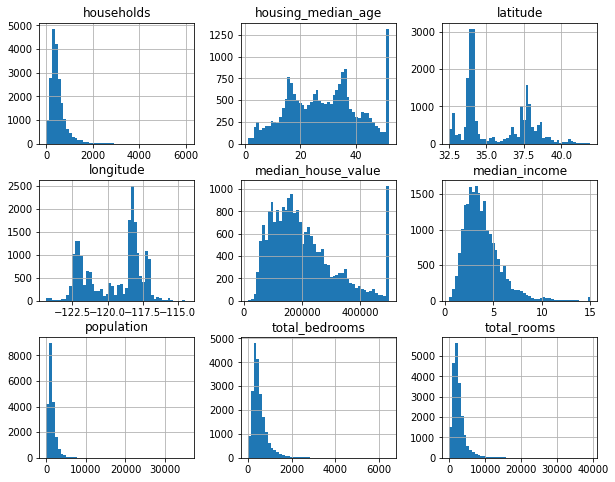

In [9]:
housing.hist(bins=50, figsize=(10, 8));

In [10]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [11]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
train_set.shape, test_set.shape

((16512, 11), (4128, 11))

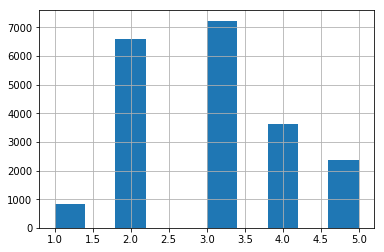

In [13]:
housing['income_cat'] = pd.cut(housing.median_income, 
                               bins=[0., 1.5, 3., 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5])
housing.income_cat.hist();

In [14]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1103)
for train_idx, test_idx in split.split(housing, housing.income_cat):
    strat_train = housing.loc[train_idx]
    strat_test = housing.loc[test_idx]

In [15]:
for data in [strat_train, strat_test]:
    print(data.income_cat.value_counts() / len(data))

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


In [16]:
for data in (strat_train, strat_test):
    data.drop('income_cat', axis=1, inplace=True)

In [17]:
housing = strat_train.copy()

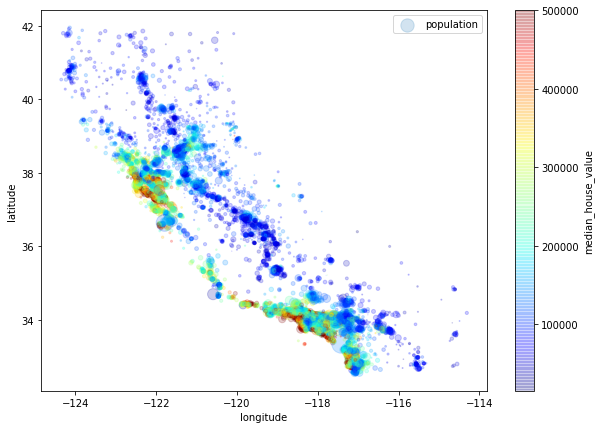

In [18]:
housing.plot(kind='scatter',
             x='longitude',
             y='latitude',
             alpha=0.2,
             s=housing['population'] / 100,
             label='population',
             figsize=(10, 7),
             c='median_house_value',
             cmap=plt.get_cmap('jet'),
             colorbar=True)
plt.legend();

In [19]:
corr_M = housing.corr()
corr_M['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691882
total_rooms           0.134490
housing_median_age    0.097914
households            0.066909
total_bedrooms        0.051152
population           -0.022312
longitude            -0.047664
latitude             -0.142845
Name: median_house_value, dtype: float64

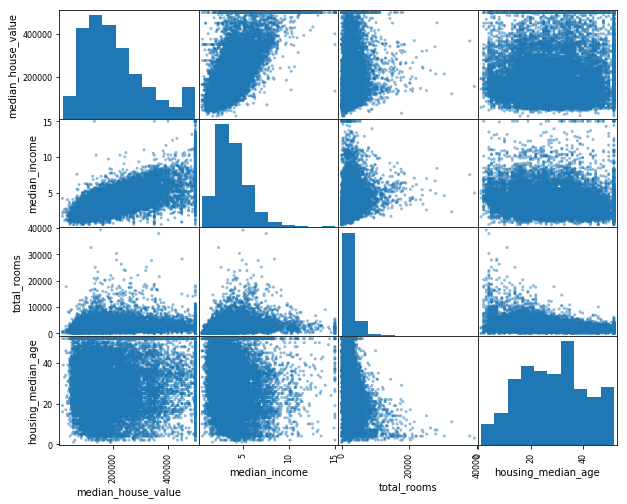

In [20]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 
              'housing_median_age']
scatter_matrix(housing[attributes], figsize=(10, 8));

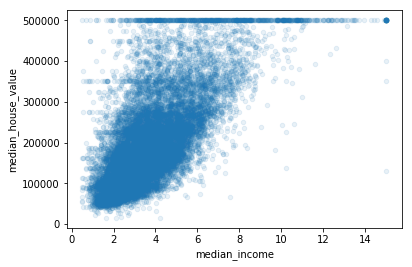

In [21]:
housing.plot(
    kind='scatter', x='median_income', y='median_house_value', alpha=0.1);

In [22]:
housing['rooms_per_household'] = housing.total_rooms / housing.households
housing['bedrooms_per_room'] = housing.total_bedrooms / housing.total_rooms
housing['pop_per_household'] = housing.population / housing.households

In [23]:
corr_M = housing.corr()
corr_M['median_house_value'].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.691882
rooms_per_household    0.149161
total_rooms            0.134490
housing_median_age     0.097914
households             0.066909
total_bedrooms         0.051152
pop_per_household     -0.021677
population            -0.022312
longitude             -0.047664
latitude              -0.142845
bedrooms_per_room     -0.264188
Name: median_house_value, dtype: float64

In [24]:
housing.dropna(subset=['total_bedrooms'], inplace=True)

In [25]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
4211,<1H OCEAN
14045,NEAR OCEAN
11207,<1H OCEAN
12726,INLAND
7926,<1H OCEAN


In [26]:
housing.ocean_proximity.unique()

array(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'],
      dtype=object)

In [27]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16347x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16347 stored elements in Compressed Sparse Row format>

In [28]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [29]:
rooms_idx, bedrooms_idx, population_idx, households_idx = 3, 4, 5, 6

In [30]:
housing_labels = housing.median_house_value.copy()
housing = housing.drop('median_house_value', axis=1)

In [31]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_idx] / X[:, households_idx]
        population_per_household = (X[:, population_idx] 
                                    / X[:, households_idx])
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
            return np.c_[X, 
                         rooms_per_household, 
                         population_per_household, 
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [32]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [33]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [34]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [35]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [36]:
full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(), cat_attribs)])
housing_prepared = full_pipeline.fit_transform(housing)

In [37]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,pop_per_household
4211,-118.25,34.10,42.0,4198.0,956.0,1935.0,878.0,3.7184,<1H OCEAN,4.781321,0.227727,2.203872
14045,-117.14,32.76,35.0,1785.0,493.0,965.0,506.0,2.0792,NEAR OCEAN,3.527668,0.276190,1.907115
11207,-117.92,33.83,52.0,1514.0,301.0,855.0,293.0,3.6042,<1H OCEAN,5.167235,0.198811,2.918089
12726,-121.35,38.60,27.0,4314.0,611.0,1662.0,575.0,5.0997,INLAND,7.502609,0.141632,2.890435
7926,-118.09,33.84,23.0,4412.0,910.0,2380.0,825.0,4.5400,<1H OCEAN,5.347879,0.206256,2.884848


In [38]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Preds: ', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Preds:  [259326.515625 189286.859375 223503.78125  193242.34375  248349.484375]
Labels: [277300.0, 160000.0, 166400.0, 170100.0, 213100.0]


In [40]:
housing_preds = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67692.6612659641

In [42]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')